In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import re
import numpy as np
import anndata as ad
from tqdm import tqdm
import squidpy as sq
from jax.config import config

config.update("jax_enable_x64", True)

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

In [2]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 21

adata_sc = ad.read(Path(path_data) / f"dataset{dataset}_sc.h5ad")
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
adata_insitu = ad.read(Path(path_data) / f"dataset{dataset}_insitu.h5ad")

In [4]:
common_genes = list(
    set(adata_sc.var_names.tolist()).intersection(adata_sp.var_names.tolist())
)

In [5]:
sc_df = sc.get.obs_df(adata_sc, keys=common_genes)
sp_df = sc.get.obs_df(adata_sp, keys=common_genes)

In [6]:
test_genes = (
    sc_df.corrwith(sp_df, method="pearson")
    .dropna()
    .sort_values(ascending=False)
    .head(10)
)
test_genes

GPIHBP1       0.259866
PDZD7         0.251807
LRAT          0.226721
CYP4X1        0.225141
TNK2-AS1      0.198250
AXDND1        0.186190
AP000442.1    0.185259
AC009506.1    0.177254
IGFBP7        0.158666
JPH2          0.154632
dtype: float64

In [8]:
test_var = np.in1d(adata_sp.var_names, test_genes.index)
train_var_sc = ~np.in1d(adata_sc.var_names, test_genes.index)
train_var_sp = ~np.in1d(adata_sp.var_names, test_genes.index)

In [9]:
adata_sp_train = adata_sp[:, train_var_sp].copy()
adata_sp_test = adata_sp[:, test_var].copy()
adata_sc_train = adata_sc[:, train_var_sc].copy()
sc.tl.pca(adata_sp_train)
sc.tl.pca(adata_sc_train)
adata_sc.obsm["X_pca"] = adata_sc_train.obsm["X_pca"].copy()
adata_sp_train.obsm["X_pca_spatial"] = np.hstack(
    [adata_sp_train.obsm["X_pca"].copy(), adata_sp_train.obsm["spatial"].copy()]
)

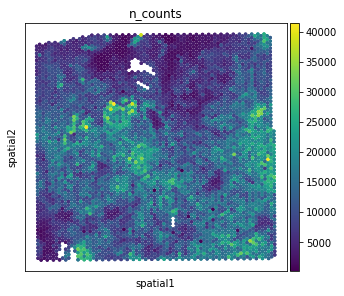

In [14]:
sq.pl.spatial_scatter(adata_sp, color=["n_counts"], shape=None)

In [15]:
from moscot.problems.space import MappingProblem

prob = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp_train)
prob = prob.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"},
    sp_attr={"attr": "obsm", "key": "X_pca_spatial"},
    callback="local-pca",
)

In [16]:
print(
    prob.problems[("src", "tgt")].xy.data.shape,
    prob.problems[("src", "tgt")].xy.data_y.shape,
)

(4895, 30) (6178, 30)


In [31]:
params = {"epsilon": 1e-2, "alpha": 1e-3}
epsilon, alpha = params["epsilon"], params["alpha"]

In [37]:
prob = prob.solve(
    alpha=alpha, epsilon=epsilon, max_iterations=500, tau_a=0.95, tau_b=1.0
)
print(prob.solutions[list(prob.solutions.keys())[0]].converged)
print(prob.solutions[list(prob.solutions.keys())[0]].cost)

kwargs are  {'epsilon': 0.01, 'alpha': 0.001, 'scale_cost': 'mean', 'batch_size': None, 'x': TaggedArray(data=ArrayView([[ 4729, 10567],
           [ 4493, 10705],
           [ 4731, 10840],
           ...,
           [22657, 26692],
           [22896, 26827],
           [22659, 26965]]), data_y=None, tag=<Tag.POINT_CLOUD: 'point_cloud'>, loss=<ott.geometry.costs.Euclidean object at 0x7f14c0b356d0>), 'y': TaggedArray(data=ArrayView([[ 4.190201  ,  2.3879673 ,  0.899675  , ..., -0.13961682,
             0.54559845,  0.29610306],
           [ 2.9964051 ,  2.286672  ,  0.6063701 , ..., -0.45411813,
             0.51694876, -0.58587545],
           [ 2.9109192 ,  2.3579202 ,  1.73161   , ...,  1.2788811 ,
             1.0134325 , -0.48318768],
           ...,
           [ 5.9814596 ,  4.362157  , -2.2350895 , ...,  0.02564228,
            -0.56750405, -1.0175769 ],
           [ 3.7518451 ,  0.16640878, -1.8953433 , ..., -0.22587472,
             0.8598054 ,  0.17442125],
           [ 3.967

In [38]:
adata_sp.var_names

Index(['AL627309.1', 'AL627309.5', 'AP006222.2', 'AL732372.1', 'AC114498.1',
       'AL669831.2', 'LINC01409', 'FAM87B', 'LINC01128', 'LINC00115',
       ...
       'MT-CYB', 'BX004987.1', 'AC145212.1', 'MAFIP', 'AC011043.1',
       'AL354822.1', 'AL592183.1', 'AC240274.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=22223)

In [39]:
adata_pred = prob.impute(var_names=test_genes.index, device="cpu")
true_df = sc.get.obs_df(adata_sp_test, keys=test_genes.index.tolist())
pred_df = sc.get.obs_df(adata_pred, keys=test_genes.index.tolist())

/home/icb/giovanni.palla/code/moscot/moscot/problems/space/_mixins.py:377: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_pred = AnnData(np.nan_to_num(np.vstack(pred_list), nan=0.0, copy=False))


In [40]:
pred_df.corrwith(true_df, method="pearson")

GPIHBP1      -0.001572
PDZD7        -0.001445
LRAT         -0.002069
CYP4X1       -0.000679
TNK2-AS1     -0.000905
AXDND1       -0.000446
AP000442.1   -0.000637
AC009506.1   -0.001846
IGFBP7       -0.029983
JPH2         -0.001711
dtype: float64

In [41]:
test_genes

GPIHBP1       0.259866
PDZD7         0.251807
LRAT          0.226721
CYP4X1        0.225141
TNK2-AS1      0.198250
AXDND1        0.186190
AP000442.1    0.185259
AC009506.1    0.177254
IGFBP7        0.158666
JPH2          0.154632
dtype: float64

In [30]:
pred_df.corrwith(true_df, method="pearson").mean()

-0.003613849387205139

In [118]:
pred_df = sc.get.obs_df(adata_sc, keys=true_df.columns.tolist())

In [119]:
pred_df.corrwith(true_df, method="pearson")

Mafk     -0.027758
Tbx2      0.016857
Cebpg     0.001562
Srebf1    0.002615
Egf      -0.015897
Nfe2l2    0.022176
Tbr1      0.001061
Bach2     0.026690
Ptch1     0.007445
Bach1    -0.007325
Mycn     -0.001995
Trp73    -0.031705
Gmeb2     0.008719
Tbx15     0.016643
Rbpj     -0.009315
Mzf1     -0.033001
Mn1      -0.000731
dtype: float64

In [120]:
pred_df.corrwith(true_df, method="pearson").mean()

-0.0014094501304268954

In [39]:
# from scipy.stats import pearsonr

# gene = "ICAM1"
# pearsonr(pred_df[gene].values, true_df[gene].values)

In [40]:
import tangram as tg
import torch

tg.pp_adatas(adata_sc, adata_sp_train, genes=adata_sp_train.var_names.tolist())

INFO:root:153 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:153 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [42]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [44]:
ad_map = tg.map_cells_to_space(adata_sc, adata_sp_train, device=device)
ad_ge = tg.project_genes(ad_map, adata_sc)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 153 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [17]:
ad_map.uns["training_history"]["kl_reg"][-1]

'0.00011053994967369363'

In [9]:
from scvi.external import GIMVI

GIMVI.setup_anndata(adata_sp_train, layer="counts")
GIMVI.setup_anndata(adata_sc, layer="counts")

Global seed set to 0
2022-08-10 19:02:27.589202: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2022-08-10 19:02:27.589506: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
model = GIMVI(adata_sc, adata_sp_train)

# train for 200 epochs
model.train(10, batch_size=256)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it, loss=1.53e+03, v_num=1]


In [11]:
imputed = model.get_imputed_values(normalized=True, batch_size=256)

ValueError: expected 2D or 3D input (got 1D input)

In [42]:
import scvi

In [43]:
scvi.__version__

'0.16.4'

In [156]:
true_df.columns = [a.lower() for a in true_df.columns]

In [157]:
pred_df = sc.get.obs_df(ad_ge, keys=true_df.columns.tolist())

In [158]:
pred_df.corrwith(true_df, method="pearson")

slc6a7     0.334347
rasgrp2    0.125879
smarcd1    0.251178
stc2      -0.015233
cited2     0.285393
             ...   
impdh1     0.169322
pim3      -0.014086
sipa1l2    0.145808
tbc1d30    0.303578
adarb1     0.217383
Length: 100, dtype: float64

In [159]:
pred_df.corrwith(true_df, method="pearson").mean()

0.17790219399325075

In [26]:
adata = adata_sp.copy()
adata.obsm["spatial"] = adata.obsm["spatial"].astype(np.float_)
sc.pp.subsample(adata, fraction=0.1)

In [27]:
adata2 = adata.copy()

In [28]:
adata = ad.concat([adata, adata2], label="batch")

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [29]:
from moscot.problems.space import AlignmentProblem

In [34]:
ap = AlignmentProblem(adata)
ap = ap.prepare(batch_key="batch", policy="star", reference="0")

In [35]:
ap.solve()

In [37]:
ap.align(reference="0", mode="affine")